# 6: Restricted Boltzmann Machines

1. After the RBM has been trained, introduce a lower “temperature” in the
sigmoid function (eventually zero: deterministic system) to generate the
hidden layer and the visible fantasy data.
2. Check if the method at point 1 yields the closest category to each data
sample, which ideally is its original category (“0”,”1”,”2”,”3”) before
random corruption of bits. An estimate of the fracton of correct category
recovery can be performed either with the method provided during the
lecture or by writing on file the true label y during data generation and by
reading it during the check.
3. Introduce a fifth state “4” (see table below) and check which is the minimum number of hidden
units M for the RBM to work properly. Eventually repeat this also when a sixth state “5” is
introduced.
4. If there is time, repeat the above points for systems with larger error rate (q>0.1) and for
systems with larger block rate (Z>2, so that L=4*Z>8). For example, for Z=3 one has L=12 and
new states would be “4”=111111111111 and “5”=100100100000.

## Reading data and training it (following what done during lesson)

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from numpy import exp

In [3]:
fname = 'dataRBM_q0,1.csv'
data = np.loadtxt(fname, delimiter=',', dtype=int)

N = len(data)
L = len(data[1])

print(f'Data len N = {N}\nDigits for wach line L = {L}')

Data len N = 10000
Digits for wach line L = 8


In [4]:
# 0 -> -1 and 1 -> 1
# Visible data
v = 2*data - 1 
# test v called v0
v0 = np.copy(v) # fix

for k in range(5):
    print(data[k], v[k])
    
# Initializing
np.random.seed(12342)

# Number of hidden units
M = 2 # as describerd in the intro, minimum number

# range of initial weight
sigma = np.sqrt( 4/(L+M) )
print(f'Sigma = {sigma}')

# initial weights (pag 98, but no gaussian)
# This example should be robust (converges
# but also because the example is simple)
w = sigma * (2*np.random.rand(L,M) - 1)
a = sigma * (2*np.random.rand(L) - 1)
b = np.zeros(M) # 0's !
print(f'w = \n{w}')
print(f'a = \n{a}')
print(f'b = \n{b}')

[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 0 1 1] [-1 -1  1  1 -1 -1  1  1]
[0 0 1 1 0 1 0 0] [-1 -1  1  1 -1  1 -1 -1]
[1 0 1 1 0 1 1 1] [ 1 -1  1  1 -1  1  1  1]
[0 0 1 1 1 1 0 0] [-1 -1  1  1  1  1 -1 -1]
Sigma = 0.6324555320336759
w = 
[[ 0.2312481  -0.1921846 ]
 [ 0.41981402 -0.35446294]
 [-0.08209399 -0.16087596]
 [-0.39923633 -0.55184291]
 [ 0.21317147 -0.16707938]
 [ 0.59531317 -0.01861671]
 [-0.02474645  0.03761957]
 [ 0.54715523  0.56265455]]
a = 
[-0.55847423 -0.61468609 -0.31559158  0.59231902 -0.46253863 -0.08086142
  0.20653201 -0.1123049 ]
b = 
[0. 0.]


x = [0, 0, 0, 0, 0, 0, 0, 0]
x = [1, 1]


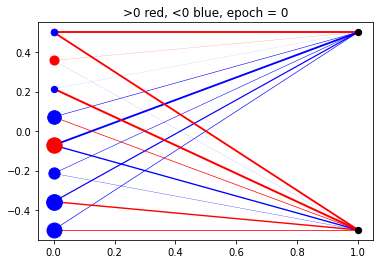

In [7]:
# For visual interpretation
def create_cord(np,x0):
    '''
    Returns the coordinates for vertically aligned layers
    np -> L or m
    x0 -> position of the layer in x axis
    '''
    x = [x0] * np
    print(f'x = {x}')
    y = list(range(np))
    for i in range(np):
        y[i] = y[i]/(np-1) - 0.5
    return (x,y)

(x1,y1) = create_cord(L,0) # visible
(x2,y2) = create_cord(M,1) # hidden

def mycolor(val):
    '''Return color w.r.t. the sign'''
    if val > 0:
        return 'red'
    elif val < 0:
        return 'blue'
    return 'black'

def plotgraph(epoch = 0):
    '''
    Display plot of the RBM's layers.
    Color represent sign while thickness of line
    represent the absolute value of the weight.
    
    epoch -> epoch of the training for label
    '''
    # Max line width = 2
    A = 2/w.max() # using weights
    for i in range(L):
        for j in range(M):
            ex, ey, col = (x1[i],x2[j]), (y1[i],y2[j]), mycolor(w[i][j])
            # zorder -> scatter plot on top of weights
            plt.plot(ex, ey, col, zorder=1, lw=A*np.abs(w[i][j]))
    
    # point size
    PS = 400
    PSmin = 40
    for i in range(L):
        plt.scatter(x1[i], y1[i], s=max(PSmin,PS*np.abs(a[i])),
                   zorder=2, c=mycolor(a[i]))
    for i in range(M):
        plt.scatter(x2[i], y2[i], s=max(PSmin,PS*np.abs(b[i])),
                   zorder=2, c=mycolor(b[i]))
    plt.title(f'>0 red, <0 blue, epoch = {epoch}')
    plt.show()
    
    
# ----------- initial configuration
plotgraph()


## 1: Introducing a 'temperature' in the sigmoid

Here we introduce the temperature through the $\beta$ parameter in the sigmoid 
$$ \sigma (x) = \frac{1}{1 + \exp{\left[-\beta x \right]}} $$

Default $\beta = 1$. Note that if $T \rightarrow 0^+$ then $\beta \rightarrow + \infty$, which gives a sigmoid either 0, for negative $x$, or 1 for positive $x$, i.e. deterministic.

In [12]:
# Activation function
# eq (213) page 97

def activate(v_in, wei, bias, beta = 1, info=False):
    '''Returns the activated array'''
    
    # activation
    act = np.dot(v_in, wei) + bias
    prob = 1/(1+exp(-act*beta))
    n = act.shape
    # list of -1's
    v_out = -np.ones(n, dtype=int)
    # list of 1's according to prob
    v_out[np.random.random_sample(n) < prob] = 1
    if info:
        print(f'input = {v_in}')
        print(f'act = {act}')
        print(f'prob = {prob}')
        print(f'output = {v_out}')
        
    return v_out


# Activation for the initial w, b and input v[0]
k = 0
activate(v[k],w,b,info=True)

input = [ 1  1 -1 -1  1  1 -1 -1]
act = [ 8.96619    -8.61047257]
prob = [9.99872363e-01 1.82154608e-04]
output = [ 1 -1]


array([ 1, -1])

------------ epoch =  1 k =  499 m =  500
dw = [[ 0.004  0.   ]
 [ 0.028 -0.056]
 [ 0.02  -0.016]
 [ 0.036  0.   ]
 [ 0.012 -0.04 ]
 [-0.008  0.036]
 [ 0.     0.028]
 [-0.056 -0.068]]
da = [ 0.016 -0.072  0.    -0.04   0.096 -0.044  0.02  -0.028]
db = [ 0.012 -0.016]
Completed epoch:  1 with l_rate =  1.0
------------ epoch =  2 k =  499 m =  500
dw = [[ 0.02       -0.07      ]
 [-0.01666667  0.04666667]
 [ 0.03333333  0.00333333]
 [ 0.03666667 -0.01333333]
 [-0.00333333  0.        ]
 [-0.02333333  0.        ]
 [-0.00333333  0.03333333]
 [-0.00333333  0.00666667]]
da = [-0.02       -0.01        0.          0.01       -0.04333333  0.00333333
  0.05        0.00333333]
db = [ 0.01333333 -0.01      ]
Completed epoch:  2 with l_rate =  0.8333333333333334
Completed epoch:  3 with l_rate =  0.7142857142857143
Completed epoch:  4 with l_rate =  0.625
Completed epoch:  5 with l_rate =  0.5555555555555556
Completed epoch:  6 with l_rate =  0.5
Completed epoch:  7 with l_rate =  0.454545454545454

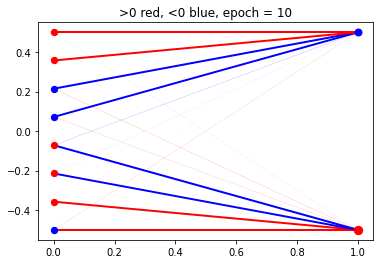

Completed epoch:  11 with l_rate =  0.3333333333333334
Completed epoch:  12 with l_rate =  0.3125000000000001
Completed epoch:  13 with l_rate =  0.29411764705882365
Completed epoch:  14 with l_rate =  0.2777777777777779
Completed epoch:  15 with l_rate =  0.2631578947368422
Completed epoch:  16 with l_rate =  0.2500000000000001
Completed epoch:  17 with l_rate =  0.2380952380952382
Completed epoch:  18 with l_rate =  0.22727272727272735
Completed epoch:  19 with l_rate =  0.21739130434782616
Completed epoch:  20 with l_rate =  0.20833333333333343


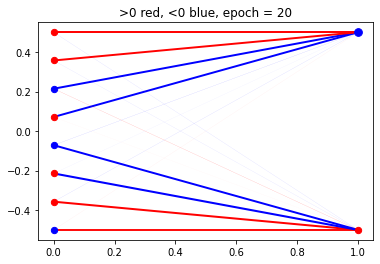

In [14]:
# Training
# learning rate
l_rate = 1.0

# Minibatch size and index m = 0, ... ,mini-1
mini, m = 500, 0
# Epochs
max_epoch = 20

# train model
for epoch in range(1,max_epoch+1):
    # changing l_rate on the fly
    l_rate_m = l_rate / mini
    
    # scan of data from the catalog
    for k in range(N):
        if m==0:
            # in the beginning of the minibatch we initialize
            # variables
            # These accumulates statistics during training
            v_data, v_model = np.zeros(L), np.zeros(L)
            h_data, h_model = np.zeros(M), np.zeros(M)
            vh_data, vh_model = np.zeros((L,M)), np.zeros((L,M))
            
        # positive CD phase: generate h
        h = activate(v[k],w,b)
        # negative CD phase: generate fantasy vf
        vf = activate(h,w.T,a) # note the transpose
        # one more positive CD phase: generate fantasy
        # h from fantasy vf
        hf = activate(vf,w,b)
        
        # Accumulate data
        v_data += v[k]
        v_model += vf
        h_data += h
        h_model += hf
        vh_data += np.outer(v[k].T,h)
        vh_model += np.outer(vf.T,hf)
        
        # next minibatch
        m += 1
        
        # When m == mini, we start the GD
        if m == mini:
            # gradient od the likelihood: follow it along its positive
            # diretion; Here we use the vanilla GD methos
            # Note: the normalization for the minibatch size is
            # done implicitly in l_rate_m
            dw = l_rate_m*(vh_data - vh_model)
            da = l_rate_m*(v_data - v_model)
            db = l_rate_m*(h_data - h_model)
            
            # see increments only for small values of epoch and k
            # just to see if GD is stable
            if epoch <= 2 and k <= mini:
                print('------------ epoch = ', epoch, 'k = ', k,
                     'm = ', m)
                print(f'dw = {dw}')
                print(f'da = {da}')
                print(f'db = {db}')
                
            # Basic step of vanilla GD, from eq (211)
            w = w+dw
            a = a+da
            b = b+db
            
            m = 0
    print('Completed epoch: ', epoch, 'with l_rate = ', l_rate)

    # randomize the order of input data
    np.random.shuffle(v)
    # let the learning rate deacy as epoch^-1
    # this is done the way it is done
    # we need a power law decay, not an exp one
    l_rate = l_rate / (.2 * l_rate + 1)
    
    # visualization
    if epoch%10 == 0:
        plotgraph(epoch)
            

## 2: Best temperature for denoising 

In [30]:
# v0 -> noised data

# defining a function to denoise data
# take as argument the temperature
def denoise(temp, save = False):
    '''
    Returns the number of structured data (i.e. that series which have
    a recognizable pattern) before and after the denoising by producing
    fantasy particles (the model is already trained).
    Moreover, it returns the array of denoised data
    (orininal, denoised, v1)
    '''
    
    # v1, vector in which save the denoised data
    v1 = np.zeros_like(v0)
    beta = 1./temp
    
    for k in range(N):
        # positive CD phase
        h = activate(v0[k],w,b,beta)
        # negative CD phase
        v1[k] = activate(h,w.T,a,beta)
    
    # difference betweeen fantasy and data
    # if elements are equale -> diff = 0
    # otherwise diff != 0
    diff = (v1 - v0)/2
    
    if save:
        str0 = 'M' + str(M) + '-mini' + str(mini) + fname
        np.savetxt('fant-'+str0, (v1+1)/2, fmt = '%d', delimiter=',')
        np.savetxt('diff-'+str0, diff, fmt = '%d', delimiter=',')

    Z = L//4
    vv0 = [0] * Z
    vv1 = [1] * Z
    case= (vv1 + vv0 + vv1 + vv0,
           vv0 + vv1 + vv1 + vv0,
           vv1 + vv0 + vv0 + vv1,
           vv0 + vv1 + vv0 + vv1)
    
    # Var in which save number of denoise data
    original = 0 # original for a comparison
    denoised = 0
    
    # .all() -> returns true if all elements are true
    for k in range(N):
        vec0 = ((v0[k]+1)/2).astype(int)
        vec1 = ((v1[k]+1)/2).astype(int)
        
        is0 = (vec1==case[0]).all()
        is1 = (vec1==case[1]).all()
        is2 = (vec1==case[2]).all()
        is3 = (vec1==case[3]).all()
        
        is0_ = (vec0==case[0]).all()
        is1_ = (vec0==case[1]).all()
        is2_ = (vec0==case[2]).all()
        is3_ = (vec0==case[3]).all()
        
        
        # if a structure is recovered, increase denoised
        if (is0 or is1 or is2 or is3):
            denoised += 1 
        # This is used to check how many pattern are recognisable
        # in the original data (note elaborated by the RBM)
        if (is0_ or is1_ or is2_ or is3_):
            original += 1
    
    return (original, denoised, v1)



# ------------- Generate different denoising as a function of the temperature T
T = [0.1, 0.5, 0.8, 1, 2, 5, 10, 100]

# List with structured data (denoised)
n_structured = []

for t in T:
    n_orig, n_den, _ = denoise(t)
    n_structured.append(n_den)

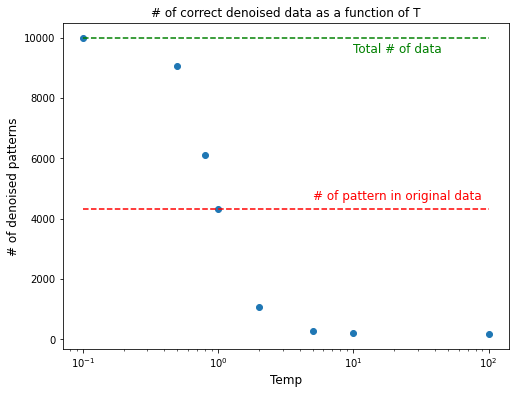

In [32]:
# Plotting
plt.figure(figsize=(8,6))

fsize = 12
plt.plot(T, n_structured, 'o')
plt.plot(T, [n_orig]*len(T), '--r') # line to denote the number of structured data in original dataset v
plt.text(T[-3], n_orig+300, '# of pattern in original data', color = 'r', fontsize=fsize)
plt.plot(T, [N]*len(T), '--g') # line for the total number of data
plt.text(T[-2], N-500, 'Total # of data', color = 'g', fontsize=fsize)
plt.title('# of correct denoised data as a function of T', fontsize=fsize)
plt.xlabel('Temp', fontsize=fsize)
plt.ylabel('# of denoised patterns', fontsize=fsize)
plt.xscale('log')
plt.show()

From the above picture we can see that when the temperature parameter drops below $0.1$, our RBM is able to completely remove noise from data by generating fantasy particles.